In [1]:
import os
import sys

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import json

import clip
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
import torch.nn.functional as f
from gradslam.structures.pointclouds import Pointclouds
from PIL import Image

from core.captioner import ClipCapCaptioner, DeCapCaptioner
from core.dataset import ScanNet
from core.extractor import GroundedSAMInstanceExtractor, LSegFeatureExtractor, SAMMaskExtractor
from core.integrate import FeatureFusionScalableTSDFVolume
from core.labeler import CLIPTextQuerier, KMeansLabeler

In [3]:
device = 'cuda:0'

In [4]:
img_A = Image.open("../../examples/test-desk.jpg")
img_B = Image.open("../../examples/test-cup.jpg")
img_C = Image.open("../../examples/test-laptop.jpg")

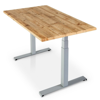

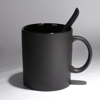

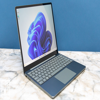

In [5]:
display(img_A.resize((100, 100)), img_B.resize((100, 100)), img_C.resize((100, 100)))

In [6]:
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
clip_model.eval().to(device);

In [7]:
A = clip_model.encode_image(preprocess(img_A).unsqueeze(0).to(device)).float().squeeze(0)
B = clip_model.encode_image(preprocess(img_B).unsqueeze(0).to(device)).float().squeeze(0)
C = clip_model.encode_image(preprocess(img_C).unsqueeze(0).to(device)).float().squeeze(0)

In [8]:
An = f.normalize(A, dim=-1)
Bn = f.normalize(B, dim=-1)
Cn = f.normalize(C, dim=-1)

In [9]:
clipcap = ClipCapCaptioner(
    clipcap_ckpt="/home/quanta/Models/ClipCap/coco_weights.pt",
    device=device,
)
clipcap.load_model()
decap = DeCapCaptioner(
    decap_ckpt="/home/quanta/Models/decap/coco_prefix-009.pt",
    device=device,
)
decap.load_model()

# Test caption result of linear combination

In [10]:
A.norm(), B.norm(), C.norm()

(tensor(10.8869, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>),
 tensor(10.9383, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>),
 tensor(10.2349, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>))

In [11]:
print(decap.get_caption(A, normalize=False))
print(decap.get_caption(B, normalize=False))
print(decap.get_caption(C, normalize=False))

a desk with a white surface and a person is standing at night 
a dark - fashioned coffee cup is sitting on a shelf 
a laptop is standing in a commercial setting 


In [12]:
print(clipcap.get_caption(A, normalize=False))
print(clipcap.get_caption(B, normalize=False))
print(clipcap.get_caption(C, normalize=False))

A wooden table with a wooden table cloth on top of it.
A black coffee mug sitting on top of a table.
A laptop computer with a blue screen on it.


In [13]:
print(decap.get_caption(A, normalize=True))
print(decap.get_caption(B, normalize=True))
print(decap.get_caption(C, normalize=True))

a desk with computer , " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " long " " " " 
a coffee mug with dark colored condiments sits in the background 
a laptop computer with a new word " 


In [14]:
print(clipcap.get_caption(A, normalize=True))
print(clipcap.get_caption(B, normalize=True))
print(clipcap.get_caption(C, normalize=True))

A man is sitting on the ground.
A man is standing next to a clock.
A person is sitting down and working on a computer.


For Clip embedding, clipcap works better than decap, especially when the feature is unnormalized.

## Test combination

In [20]:
print(decap.get_caption(An + Bn, normalize=False))
print(decap.get_caption(Bn + Cn, normalize=False))
print(decap.get_caption(Cn + An, normalize=False))

a dark - colored kitchen desk with coffee table and scissors 
a laptop computer is sitting in a dark 
a laptop computer is on a gray desk 


In [21]:
print(decap.get_caption(An + Bn, normalize=True))
print(decap.get_caption(Bn + Cn, normalize=True))
print(decap.get_caption(Cn + An, normalize=True))

a dark - colored coffee desk with a microwave , " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " 
a coffee mug with a blurry background 
a laptop computer with " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " tall " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " long " " " " 


In [22]:
print(clipcap.get_caption(A + B, normalize=True))
print(clipcap.get_caption(B + C, normalize=True))
print(clipcap.get_caption(C + A, normalize=True))

A man is sitting on the ground.
A man is standing next to a clock.
A man is standing next to a bench.


In [23]:
print(clipcap.get_caption(A + B, normalize=False))
print(clipcap.get_caption(B + C, normalize=False))
print(clipcap.get_caption(C + A, normalize=False))

A black and white photo of a cupboard with a white table.
A black and silver laptop sitting on a desk.
A laptop computer sitting on top of a wooden table.


In [24]:
print(clipcap.get_caption((A + B) / 2, normalize=False))
print(clipcap.get_caption((B + C) / 2, normalize=False))
print(clipcap.get_caption((C + A) / 2, normalize=False))

A wooden table with a cupboard and a black and white clock.
A black coffee cup sitting on top of a desk.
A laptop computer sitting on top of a wooden table.


In [25]:
print(decap.get_caption(An + Bn + Cn, normalize=True))
print(decap.get_caption(An + Bn + Cn, normalize=False))

a computer desk with coffee , striped cabinets 
a computer desk with a grey lap top 


In [26]:
print(clipcap.get_caption(A + B + C, normalize=False))
print(clipcap.get_caption((A + B + C) / 3, normalize=False))

A black and silver laptop sitting on a desk.
A computer mouse sitting on top of a wooden table.


In [33]:
print(decap.get_caption(An + Bn + 2 * Cn, normalize=True))
print(clipcap.get_caption((A + B + 2 * C) / 4, normalize=False))

a laptop computer with " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " tall " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " long " " " " 
A computer mouse sitting on top of a desk.


# Relative position decoding

In [34]:
img1 = Image.open("../../examples/apple-on-chair.jpg")
img2 = Image.open("../../examples/cup_on_desk.jpg")
img3 = Image.open("../../examples/cup_under_desk.jpg")
img4 = Image.open("../../examples/desk_font_cup_back_laptop.jpg")

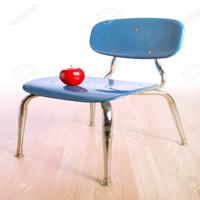

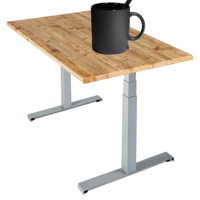

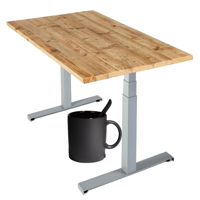

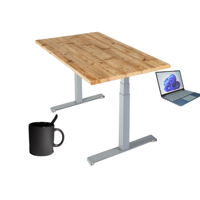

In [38]:
display(img1.resize((200, 200)))
display(img2.resize((200, 200)))
display(img3.resize((200, 200)))
display(img4.resize((200, 200)))

In [35]:
e1 = clip_model.encode_image(preprocess(img1).unsqueeze(0).to(device)).float().squeeze(0)
e2 = clip_model.encode_image(preprocess(img2).unsqueeze(0).to(device)).float().squeeze(0)
e3 = clip_model.encode_image(preprocess(img3).unsqueeze(0).to(device)).float().squeeze(0)
e4 = clip_model.encode_image(preprocess(img4).unsqueeze(0).to(device)).float().squeeze(0)

In [36]:
e1n = f.normalize(e1, dim=-1)
e2n = f.normalize(e2, dim=-1)
e3n = f.normalize(e3, dim=-1)
e4n = f.normalize(e4, dim=-1)

In [42]:
print(decap.get_caption(e1n, normalize=True))
print(clipcap.get_caption(e1, normalize=False))

picture of a school office desk with a fork , " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " 
A chair sitting on top of a wooden floor.


In [43]:
print(decap.get_caption(e2n, normalize=True))
print(clipcap.get_caption(e2, normalize=False))

this dark - colored desk with coffee table , " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " 
A wooden table with a cupboard and a wooden tablecloth.


In [44]:
print(decap.get_caption(e3n, normalize=True))
print(clipcap.get_caption(e3, normalize=False))

computer desk with coffee , striped cabinets , and coffee table 
A wooden table with a wooden table cloth on top of it.


In [45]:
print(decap.get_caption(e4n, normalize=True))
print(clipcap.get_caption(e4, normalize=False))

computer desk with coffee , and electronic device 
A wooden table with a laptop computer on top of it.


: 